In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns # for plot visualization

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import skew

# Input data files are available in the "../input/" directory.
import os
print(os.listdir("../input"))

['new-york-city-taxi-fare-prediction']


In [3]:
test_dataset = pd.read_csv('../input/new-york-city-taxi-fare-prediction/test.csv')
train_dataset = pd.read_csv('../input/new-york-city-taxi-fare-prediction/train.csv', nrows=50000)

In [4]:
train_dataset.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
train_dataset.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [6]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                50000 non-null  object 
 1   fare_amount        50000 non-null  float64
 2   pickup_datetime    50000 non-null  object 
 3   pickup_longitude   50000 non-null  float64
 4   pickup_latitude    50000 non-null  float64
 5   dropoff_longitude  50000 non-null  float64
 6   dropoff_latitude   50000 non-null  float64
 7   passenger_count    50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


In [7]:
train_dataset.drop(labels='key', axis=1, inplace=True)
test_dataset.drop(labels='key', axis=1, inplace=True)

In [8]:
train_dataset.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [9]:
print(f'Row count before drop-null operation - {train_dataset.shape[0]}')
train_dataset.dropna(inplace = True)
print(f'Row count after drop-null operation - {train_dataset.shape[0]}')

Row count before drop-null operation - 50000
Row count after drop-null operation - 50000


In [10]:
train_dataset['pickup_datetime'] = pd.to_datetime(arg=train_dataset['pickup_datetime'], infer_datetime_format=True)
test_dataset['pickup_datetime'] = pd.to_datetime(arg=test_dataset['pickup_datetime'], infer_datetime_format=True)

In [11]:
def add_new_date_time_features(dataset):
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['year'] = dataset.pickup_datetime.dt.year
    dataset['day_of_week'] = dataset.pickup_datetime.dt.dayofweek
    
    return dataset

train_dataset = add_new_date_time_features(train_dataset)
test_dataset = add_new_date_time_features(test_dataset)

In [12]:
train_dataset.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,day_of_week
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840,13.489080,15.672040,6.273300,2011.739260,3.029980
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195,6.506935,8.660789,3.461157,1.862639,1.956936
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000,0.000000,1.000000,1.000000,2009.000000,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734372,1.000000,9.000000,8.000000,3.000000,2010.000000,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000,14.000000,16.000000,6.000000,2012.000000,3.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000,19.000000,23.000000,9.000000,2013.000000,5.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000,23.000000,31.000000,12.000000,2015.000000,6.000000


In [13]:
print(f'Rows before removing coordinate outliers - {train_dataset.shape[0]}')

train_dataset = train_dataset[train_dataset.pickup_longitude.between(test_dataset.pickup_longitude.min(), test_dataset.pickup_longitude.max())]
train_dataset = train_dataset[train_dataset.pickup_latitude.between(test_dataset.pickup_latitude.min(), test_dataset.pickup_latitude.max())]
train_dataset = train_dataset[train_dataset.dropoff_longitude.between(test_dataset.dropoff_longitude.min(), test_dataset.dropoff_longitude.max())]
train_dataset = train_dataset[train_dataset.dropoff_latitude.between(test_dataset.dropoff_latitude.min(), test_dataset.dropoff_latitude.max())]

print(f'Rows after removing coordinate outliers - {train_dataset.shape[0]}')

Rows before removing coordinate outliers - 50000
Rows after removing coordinate outliers - 48927


In [14]:
train_dataset.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,day_of_week
count,48927.000000,48927.000000,48927.000000,48927.000000,48927.000000,48927.000000,48927.000000,48927.000000,48927.000000,48927.000000,48927.000000
mean,11.347919,-73.975074,40.751211,-73.973913,40.751686,1.669160,13.483823,15.663274,6.274429,2011.739755,3.030781
std,9.603617,0.038589,0.030216,0.037585,0.032828,1.290126,6.503363,8.660041,3.461936,1.865557,1.956491
min,-5.000000,-74.248263,40.580248,-74.241953,40.574652,0.000000,0.000000,1.000000,1.000000,2009.000000,0.000000
25%,6.000000,-73.992291,40.736547,-73.991325,40.735945,1.000000,9.000000,8.000000,3.000000,2010.000000,1.000000
50%,8.500000,-73.982118,40.753457,-73.980478,40.754135,1.000000,14.000000,16.000000,6.000000,2012.000000,3.000000
75%,12.500000,-73.968395,40.767781,-73.965318,40.768493,2.000000,19.000000,23.000000,9.000000,2013.000000,5.000000
max,200.000000,-73.137393,41.650000,-73.137393,41.543217,6.000000,23.000000,31.000000,12.000000,2015.000000,6.000000


In [15]:
 train_dataset.fare_amount[(train_dataset.fare_amount <= 0) | (train_dataset.fare_amount >= 350)].count()

8

In [16]:
print(f'Row count before elimination - {train_dataset.shape[0]}')
train_dataset = train_dataset[train_dataset.fare_amount.between(0, 350, inclusive=False)]
print(f'Row count after elimination - {train_dataset.shape[0]}')

Row count before elimination - 48927
Row count after elimination - 48919


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  


In [17]:
train_dataset.passenger_count[(train_dataset.passenger_count < 1) | (train_dataset.passenger_count > 8)].count()

159

In [18]:
print(f'Row count before elimination - {train_dataset.shape[0]}')
train_dataset = train_dataset[train_dataset.passenger_count.between(0, 8, inclusive=False)]
print(f'Row count after elimination - {train_dataset.shape[0]}')

Row count before elimination - 48919
Row count after elimination - 48760


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  


In [19]:
def degree_to_radion(degree):
    return degree*(np.pi/180)

def calculate_distance(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude):
    
    from_lat = degree_to_radion(pickup_latitude)
    from_long = degree_to_radion(pickup_longitude)
    to_lat = degree_to_radion(dropoff_latitude)
    to_long = degree_to_radion(dropoff_longitude)
    
    radius = 6371.01
    
    lat_diff = to_lat - from_lat
    long_diff = to_long - from_long

    a = np.sin(lat_diff / 2)**2 + np.cos(degree_to_radion(from_lat)) * np.cos(degree_to_radion(to_lat)) * np.sin(long_diff / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return radius * c

In [20]:
train_dataset['distance'] = calculate_distance(train_dataset.pickup_latitude, train_dataset.pickup_longitude, train_dataset.dropoff_latitude, train_dataset.dropoff_longitude)
test_dataset['distance'] = calculate_distance(test_dataset.pickup_latitude, test_dataset.pickup_longitude, test_dataset.dropoff_latitude, test_dataset.dropoff_longitude)

In [21]:
train_dataset.sort_values(by='distance')

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,day_of_week,distance
49999,10.90,2010-01-13 08:13:14+00:00,-73.932603,40.763805,-73.932603,40.763805,1,8,13,1,2010,2,0.000000
3945,5.30,2010-03-28 03:33:00+00:00,-73.984912,40.736457,-73.984912,40.736457,2,3,28,3,2010,6,0.000000
26128,4.90,2011-03-26 08:09:00+00:00,-73.987920,40.719040,-73.987920,40.719040,1,8,26,3,2011,5,0.000000
26149,8.10,2012-07-11 08:14:26+00:00,-73.990304,40.732206,-73.990304,40.732206,1,8,11,7,2012,2,0.000000
26289,4.50,2011-03-05 07:17:00+00:00,-73.957178,40.780193,-73.957178,40.780193,5,7,5,3,2011,5,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40574,6.10,2010-06-28 12:56:43+00:00,-73.137393,41.366138,-73.977323,40.751652,1,12,28,6,2010,0,115.716581
46009,6.10,2009-10-17 00:17:27+00:00,-73.979170,40.727777,-73.137393,41.366138,1,0,17,10,2009,5,117.467357
1684,2.50,2009-05-02 19:01:01+00:00,-73.137393,41.366138,-73.996510,40.745320,2,19,2,5,2009,5,117.856107
5663,49.15,2009-02-25 07:05:05+00:00,-73.137393,41.366138,-74.000940,40.731723,1,7,25,2,2009,2,119.144627


In [22]:
train_dataset.distance[(train_dataset.distance == 0)].count()

531

In [23]:
train_dataset[(train_dataset.pickup_latitude != train_dataset.dropoff_latitude) &
              (train_dataset.pickup_longitude != train_dataset.dropoff_latitude) &
              (train_dataset.distance == 0)].count()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
hour                 0
day                  0
month                0
year                 0
day_of_week          0
distance             0
dtype: int64

In [24]:
def add_distances_from_airport(dataset):
    #coordinates of all these airports
    jfk_coords = (40.639722, -73.778889)
    ewr_coords = (40.6925, -74.168611)
    lga_coords = (40.77725, -73.872611)

    dataset['pickup_jfk_distance'] = calculate_distance(jfk_coords[0], jfk_coords[1], dataset.pickup_latitude, dataset.pickup_longitude)
    dataset['dropof_jfk_distance'] = calculate_distance(jfk_coords[0], jfk_coords[1], dataset.dropoff_latitude, dataset.dropoff_longitude)
    
    dataset['pickup_ewr_distance'] = calculate_distance(ewr_coords[0], ewr_coords[1], dataset.pickup_latitude, dataset.pickup_longitude)
    dataset['dropof_ewr_distance'] = calculate_distance(ewr_coords[0], ewr_coords[1], dataset.dropoff_latitude, dataset.dropoff_longitude)
    
    dataset['pickup_lga_distance'] = calculate_distance(lga_coords[0], lga_coords[1], dataset.pickup_latitude, dataset.pickup_longitude)
    dataset['dropof_lga_distance'] = calculate_distance(lga_coords[0], lga_coords[1], dataset.dropoff_latitude, dataset.dropoff_longitude)
    
    return dataset


train_dataset = add_distances_from_airport(train_dataset)
test_dataset = add_distances_from_airport(test_dataset)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

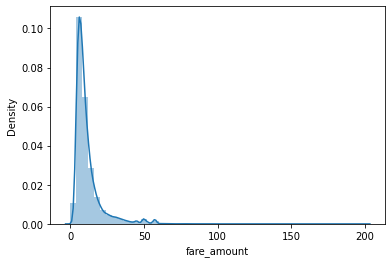

In [25]:
sns.distplot(a=train_dataset.fare_amount)

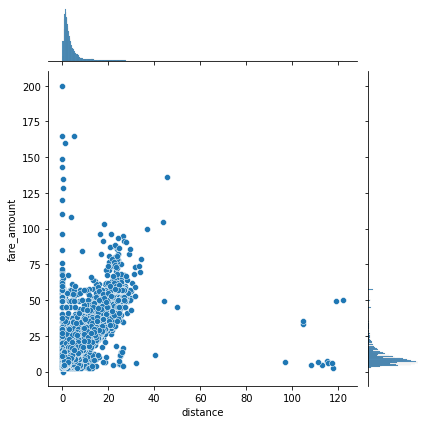

In [26]:
sns.jointplot(x='distance', y='fare_amount', data=train_dataset)

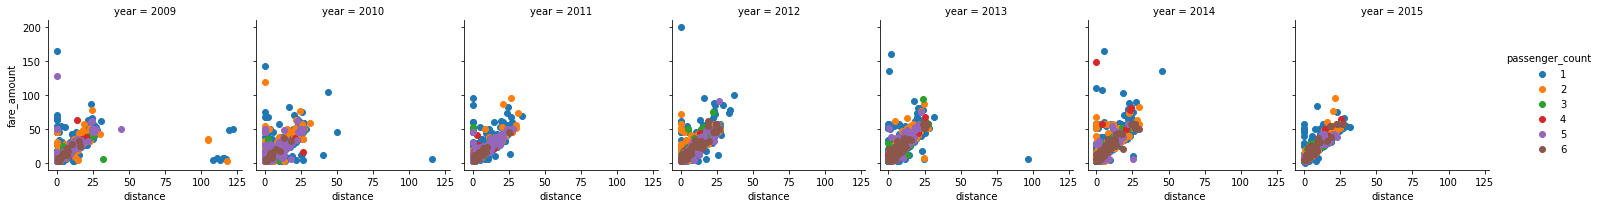

In [27]:
g = sns.FacetGrid(train_dataset, col="year", hue="passenger_count")
g.map(plt.scatter, "distance", "fare_amount")
g.add_legend()

In [28]:
train_dataset[(train_dataset.distance>90) & (train_dataset.fare_amount<70)]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,day_of_week,distance,pickup_jfk_distance,dropof_jfk_distance,pickup_ewr_distance,dropof_ewr_distance,pickup_lga_distance,dropof_lga_distance
1684,2.50,2009-05-02 19:01:01+00:00,-73.137393,41.366138,-73.996510,40.745320,2,19,2,5,2009,5,117.856107,107.758561,26.895102,136.957752,20.016401,104.739617,14.226074
3075,6.90,2009-01-06 10:53:36+00:00,-73.137393,41.366138,-73.974598,40.751311,1,10,6,1,2009,1,115.494635,107.758561,25.049336,136.957752,22.541085,104.739617,11.700650
4487,4.90,2009-08-26 07:43:16+00:00,-73.137393,41.366138,-73.957685,40.765644,1,7,26,8,2009,2,113.035660,107.758561,24.315771,136.957752,24.822420,104.739617,9.546712
5663,49.15,2009-02-25 07:05:05+00:00,-73.137393,41.366138,-74.000940,40.731723,1,7,25,2,2009,2,119.144627,107.758561,26.724622,136.957752,19.146132,104.739617,15.139900
7401,4.50,2009-07-16 09:41:26+00:00,-73.900571,40.764047,-73.137393,41.366138,1,9,16,7,2009,3,108.086775,19.343138,107.758561,30.846045,136.957752,3.437998,104.739617
9808,6.90,2009-08-13 23:15:28+00:00,-73.137393,41.366138,-73.952331,40.786380,1,23,13,8,2009,3,111.203476,107.758561,25.255270,136.957752,26.215483,104.739617,8.921738
9899,7.70,2009-08-12 19:04:53+00:00,-73.974361,40.755168,-73.137393,41.366138,1,19,12,8,2009,2,115.219989,25.241835,107.758561,22.694302,136.957752,11.576623,104.739617
17081,33.47,2009-08-21 13:51:57+00:00,-73.137393,41.366138,-73.865796,40.770828,2,13,21,8,2009,4,104.599751,107.758561,17.489987,136.957752,34.777255,104.739617,1.041199
22804,35.05,2009-07-10 11:57:05+00:00,-73.137393,41.366138,-73.871245,40.774182,2,11,10,7,2009,4,104.834984,107.758561,18.138037,136.957752,34.287944,104.739617,0.373428
29007,50.00,2009-03-24 11:49:20+00:00,-73.137393,41.366138,-74.011292,40.702179,1,11,24,3,2009,1,122.033206,107.758561,26.757098,136.957752,17.524837,104.739617,17.533997


<AxesSubplot:xlabel='day_of_week', ylabel='count'>

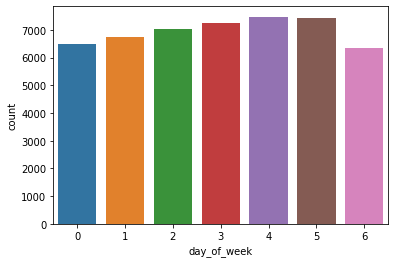

In [29]:
sns.countplot(x='day_of_week', data=train_dataset)

<AxesSubplot:xlabel='month', ylabel='day_of_week'>

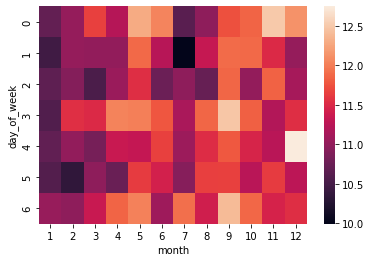

In [30]:
tc = train_dataset.pivot_table(index='day_of_week', columns='month', values='fare_amount')
sns.heatmap(data = tc)

In [31]:
train_dataset['fare_amount'].skew()

3.474751158035961

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

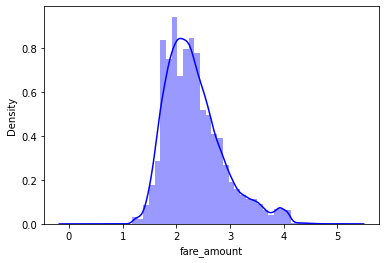

In [32]:
train_dataset['fare_amount'] = np.log1p(train_dataset['fare_amount'])
sns.distplot(train_dataset['fare_amount'], color='blue')

In [33]:
selected_predictors = [
    'pickup_longitude', 
    'pickup_latitude', 
    'dropoff_longitude', 
    'dropoff_latitude',
    'pickup_jfk_distance',
    'dropof_jfk_distance',
    'pickup_ewr_distance',
    'dropof_ewr_distance',
    'pickup_lga_distance',
    'dropof_lga_distance',
    'hour',
    'month',
    'year',
    'distance'
]

X = train_dataset.loc[:, selected_predictors].values
y = train_dataset.iloc[:, 0].values
X_test_dataset = test_dataset.loc[:, selected_predictors].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/20)

In [34]:
rand_forest_regressor = RandomForestRegressor()
rand_forest_regressor.fit(X_train, y_train)

y_rand_forest_predict = rand_forest_regressor.predict(X_test)
random_forest_model_error = sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_rand_forest_predict)))
print(f' Random Forest Mean Squared Error - {random_forest_model_error}')

 Random Forest Mean Squared Error - 3.5683279241632695


In [35]:
XGB_model = XGBRegressor(learning_rate=0.3, max_depth=6, n_estimators=500)
XGB_model.fit(X_train, y_train)
y_XGB_predict = XGB_model.predict(X_test)

XGB_model_error = sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_XGB_predict)))

print(f'XGBoost Mean Squared Error - {XGB_model_error}')

XGBoost Mean Squared Error - 3.5045677450756267


<AxesSubplot:>

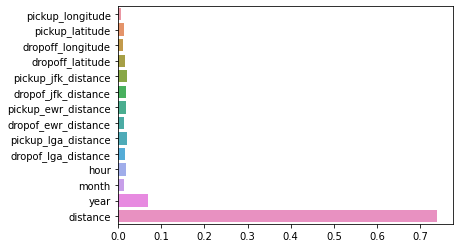

In [36]:
sns.barplot(y=list(train_dataset.loc[:, selected_predictors].columns), x=list(XGB_model.feature_importances_))

In [37]:
lgb_model = lgb.LGBMRegressor(objective='regression',num_leaves=35, n_estimators=300)

lgb_model.fit(X_train, y_train)
y_LGB_predict = lgb_model.predict(X_test)

LGB_model_error = sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_LGB_predict)))

print(f'LGBM Mean Squared Error - {LGB_model_error}')

LGBM Mean Squared Error - 3.4826659621844063


In [38]:
ensembled_prediction = (0.5*np.expm1(y_XGB_predict))+(0.5*np.expm1(y_LGB_predict))
ensembled_prediction_error = sqrt(mean_squared_error(np.expm1(y_test), ensembled_prediction))

print(f'Ensembled Mean Squared Error - {ensembled_prediction_error}')

Ensembled Mean Squared Error - 3.390380167330668


In [40]:
# making prediction using test_dataset predictors
y_XGB_predict = np.expm1(XGB_model.predict(X_test_dataset))

# submitting our predictions
submission = pd.read_csv('../input/new-york-city-taxi-fare-prediction/sample_submission.csv')
submission['fare_amount'] = y_XGB_predict
submission.to_csv('xgb_submission.csv', index=False)
submission.head(10)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.109556
1,2015-01-27 13:08:24.0000003,10.474855
2,2011-10-08 11:53:44.0000002,4.481828
3,2012-12-01 21:12:12.0000002,8.893833
4,2012-12-01 21:12:12.0000003,16.215553
5,2012-12-01 21:12:12.0000005,9.270201
6,2011-10-06 12:10:20.0000001,5.152874
7,2011-10-06 12:10:20.0000003,52.636902
8,2011-10-06 12:10:20.0000002,11.467382
9,2014-02-18 15:22:20.0000002,6.885140


In [41]:
y_LGB_predict = np.expm1(lgb_model.predict(X_test_dataset))

# submitting our predictions
submission = pd.read_csv('../input/new-york-city-taxi-fare-prediction//sample_submission.csv')
submission['fare_amount'] = y_LGB_predict
submission.to_csv('lgbm_submission.csv', index=False)
submission.head(10)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.211845
1,2015-01-27 13:08:24.0000003,10.610685
2,2011-10-08 11:53:44.0000002,4.295067
3,2012-12-01 21:12:12.0000002,8.500779
4,2012-12-01 21:12:12.0000003,16.190936
5,2012-12-01 21:12:12.0000005,9.494406
6,2011-10-06 12:10:20.0000001,5.002471
7,2011-10-06 12:10:20.0000003,51.927408
8,2011-10-06 12:10:20.0000002,10.792864
9,2014-02-18 15:22:20.0000002,6.645799


In [42]:
ensembled_prediction = (0.5*y_XGB_predict)+(0.5*y_LGB_predict)
submission.to_csv('ensembled_submission.csv', index=False)
submission.head(10)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.211845
1,2015-01-27 13:08:24.0000003,10.610685
2,2011-10-08 11:53:44.0000002,4.295067
3,2012-12-01 21:12:12.0000002,8.500779
4,2012-12-01 21:12:12.0000003,16.190936
5,2012-12-01 21:12:12.0000005,9.494406
6,2011-10-06 12:10:20.0000001,5.002471
7,2011-10-06 12:10:20.0000003,51.927408
8,2011-10-06 12:10:20.0000002,10.792864
9,2014-02-18 15:22:20.0000002,6.645799
